In [1]:
import numpy as np 
import pandas as pd 

import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization,Activation,Input,UpSampling2D,Lambda
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import regularizers
import cv2
from tqdm import tqdm
import random
import numpy as np
from tensorflow.keras.utils import Sequence
import random
from keras import backend as K
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import resnet

In [2]:
K.clear_session()

In [3]:
IMG_SIZE = 256

In [4]:
epochs = 20
batch_size = 4
margin = 1  # Margin for constrastive loss.

In [5]:
def load_image_from_path(path):
    
    image = tf.io.read_file(prefix + path)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, size = (IMG_SIZE, IMG_SIZE))
    
    return image/255.

In [6]:
def balance(X, y_, limit=40):
    
    balanced_X = []
    balanced_y = []
    
    y = y_.squeeze()
    for i in range(y.max()):
        if( len(y[y == i]) > limit):
            balanced_X.append(X[y == i][:limit])
            balanced_y.append(y[y == i][:limit])
        else:
            balanced_X.append(X[y == i])
            balanced_y.append(y[y == i])
            
    return np.array([y for x in balanced_X for y in x]), np.array([y for x in balanced_y for y in x])

In [7]:
# example = pd.read_csv('examples_of_retrieval.csv', sep="\t")
# retrievals=[]
# retrievals.append([x.replace(" ", "") for x in example.columns[0].split(",")])
# for i in example.index:
#     retrievals.append([x.replace(" ", "") for x in example.iloc[i].values[0].split(",")])

In [8]:
# def has_duplicates(values):
#     if len(values) != len(set(values)):
#         return True
#     else:
#         return False

# not_dupli =[]
# for x in retrievals:
#     if has_duplicates(x):
#         to_add = []
#         for j in x:
#             if(j not in to_add):
#                 to_add.append(j)
#         not_dupli.append(to_add)
#     else:
#         not_dupli.append(x)

In [9]:
# cont = 0
# total = 0
# for x in retrievals:
#     if(len(x) < 4):
#         print(len(x))
#         cont +=1
#     total += len(x)    
# print(f"menores que 5:{cont} de {total}")

In [10]:
# r = [x for x in retrievals if(len(x) > 4)]

In [11]:
# rr = []
# for x in r:
#     if len(x) > 5:
#         rr.append(x[:5])
#     else:
#         rr.append(x)

In [12]:
# cont = 0
# groups = pd.DataFrame(columns=['ID', 'new_cluster'])
# for x in rr:
#     fixed = [" "+j for j in x]
#     groups = pd.concat([groups, pd.DataFrame({'ID':fixed, 'new_cluster':[cont for z in range(len(fixed))]})], axis=0) 
#     cont += 1

In [13]:
groups = pd.read_csv('aux_cluster.csv')

mask = groups.groupby('new_cluster').size() < 4 
mask = mask[mask == True].index

groups = groups[~groups.new_cluster.isin(mask)][['ID', 'new_cluster']]

list_of_indices = groups.new_cluster.unique().copy()
for i, cluster_index in enumerate(list_of_indices):
    indices = groups[groups.new_cluster == cluster_index].index
    groups.loc[indices, 'new_cluster'] = i

In [14]:
prefix = 'dataset/database-full/'

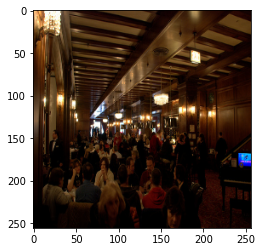

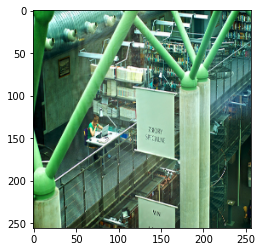

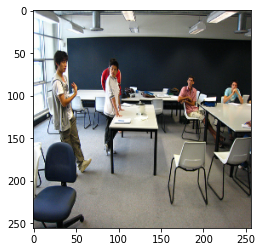

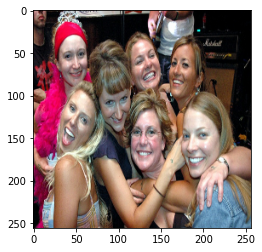

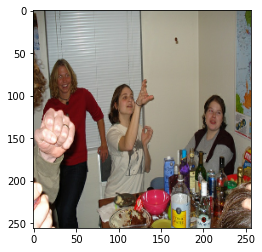

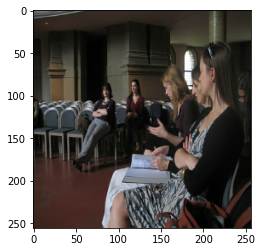

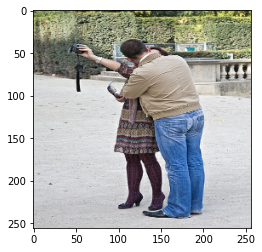

In [15]:
cluster = groups[groups.new_cluster == 64][:20]
for i, x in cluster.iterrows():
    plt.imshow(load_image_from_path(x.ID))
    plt.show()

In [16]:
#groups['ID'] = groups.ID.apply(lambda row: prefix+ row)

In [17]:
X = groups.ID.values
y = groups.new_cluster.values

X, y = balance(X, y, limit=5)

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=.3, random_state=42)

In [18]:
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")


# make train pairs
pairs_train, labels_train = make_pairs(X_train, y_train)

# make validation pairs
pairs_val, labels_val = make_pairs(X_val, y_val)

In [19]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]

x_val_1 = pairs_val[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_val_2 = pairs_val[:, 1]

In [20]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(16, 15))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([load_image_from_path(pairs[i][0]), load_image_from_path(pairs[i][1])], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()


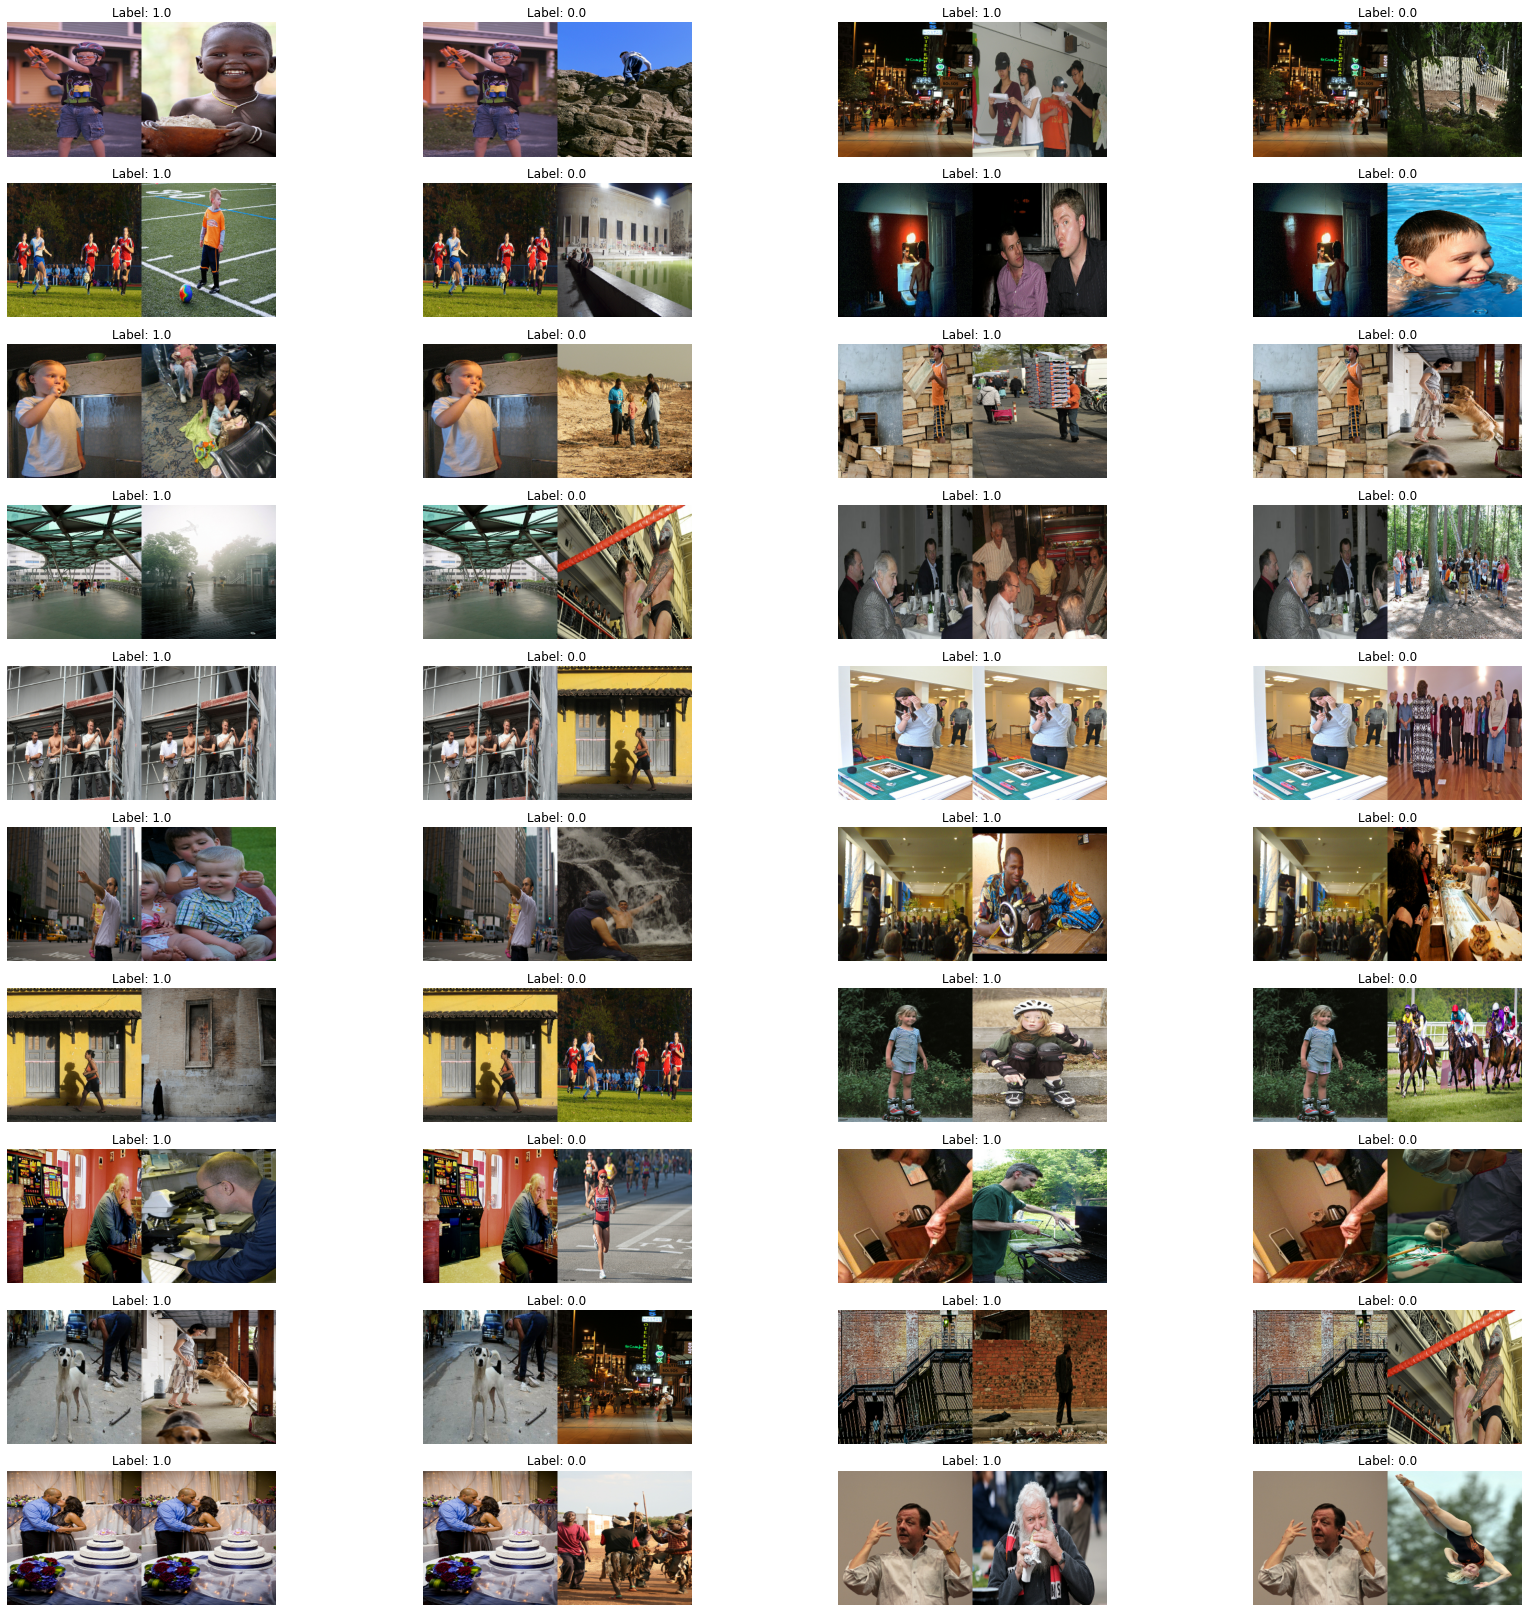

In [21]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=40, num_col=4)

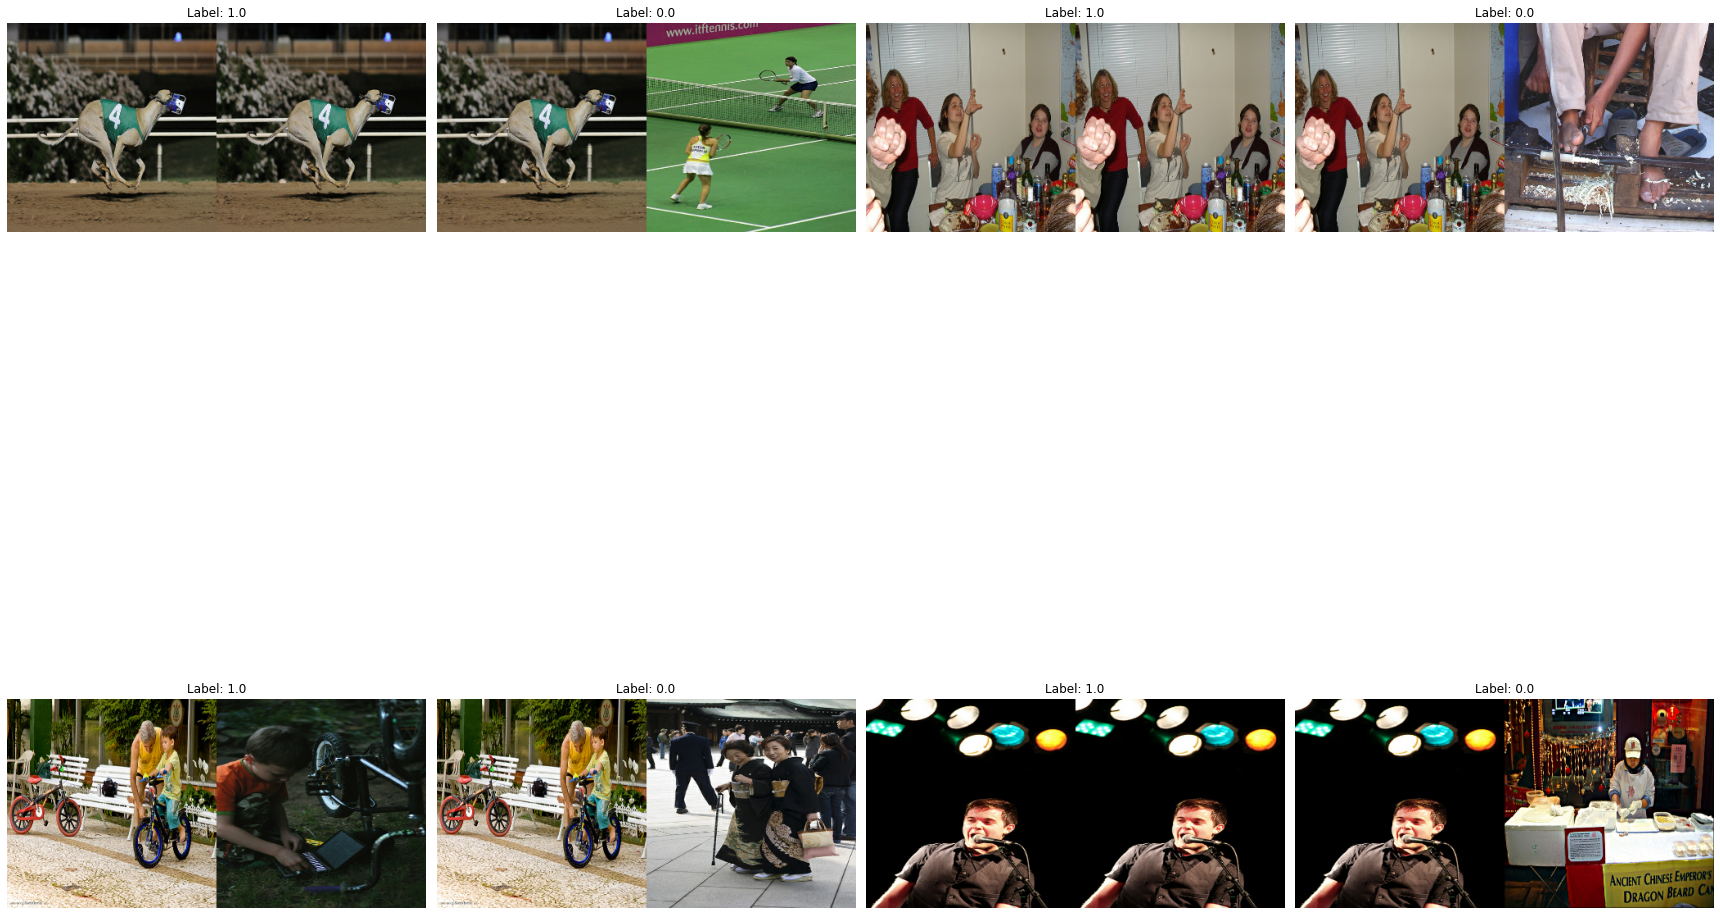

In [22]:
visualize(pairs_val[:-1], labels_val[:-1], to_show=8, num_col=4)

In [23]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))



base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, classes=2,
)

for layer in base_cnn.layers:
        layer.trainable=False

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding_network = Model(base_cnn.input, output, name="embedding_network")

# trainable = False
# for layer in base_cnn.layers:
#     if layer.name == "conv5_block1_out":
#         trainable = True
#     layer.trainable = trainable




# input = layers.Input((IMG_SIZE, IMG_SIZE, 3))
# x = tf.keras.layers.BatchNormalization()(input)
# x = layers.Conv2D(64, (5, 5), activation="tanh")(x)
# x = layers.AveragePooling2D(pool_size=(2, 2))(x)
# x = layers.Conv2D(64, (5, 5), activation="tanh")(x)
# x = layers.AveragePooling2D(pool_size=(2, 2))(x)
# x = layers.Flatten()(x)

# x = tf.keras.layers.BatchNormalization()(x)
# x = layers.Dense(64, activation="tanh")(x)
# embedding_network = keras.Model(input, x)


input_1 = layers.Input((IMG_SIZE, IMG_SIZE, 3))
input_2 = layers.Input((IMG_SIZE, IMG_SIZE, 3))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance, name='merge')([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization(name='norm')(merge_layer)
drop_layer = layers.Dropout(.1, name='drop')(normal_layer)
output_layer = layers.Dense(1, activation="sigmoid", name='output')(drop_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)



In [24]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss


In [25]:
siamese.compile(
    loss=loss(margin),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.005), 
    metrics=["accuracy"])
siamese.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding_network (Functional)  (None, 256)         90897280    ['input_2[0][0]',                
                                                                  'input_3[0][0]']            

In [26]:
X_train_set1 = tf.data.Dataset.from_tensor_slices(x_train_1)
X_train_set1 = (
    X_train_set1
    .map(load_image_from_path, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

X_train_set2 = tf.data.Dataset.from_tensor_slices(x_train_2)
X_train_set2 = (
    X_train_set2
    .map(load_image_from_path, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

X_val_set1 = tf.data.Dataset.from_tensor_slices(x_val_1)
X_val_set1 = (
    X_val_set1
    .map(load_image_from_path, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

X_val_set2 = tf.data.Dataset.from_tensor_slices(x_val_2)
X_val_set2 = (
    X_val_set2
    .map(load_image_from_path, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


labels_set = tf.data.Dataset.from_tensor_slices(labels_train.reshape(-1, 1)).batch(batch_size)
val_labels_set = tf.data.Dataset.from_tensor_slices(labels_val.reshape(-1, 1)).batch(batch_size)
dataset_mix = tf.data.Dataset.zip((X_train_set1, X_train_set2, labels_set)).map(lambda x,y,z: ((x,y),z))
val_dataset_mix = tf.data.Dataset.zip((X_val_set1, X_val_set2, val_labels_set)).map(lambda x,y,z: ((x,y),z))


history = siamese.fit(
    dataset_mix,
    validation_data=val_dataset_mix,
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/20
242/242 [==============================] - 56s 200ms/step - loss: 0.2749 - accuracy: 0.4337 - val_loss: 0.4124 - val_accuracy: 0.2019
Epoch 2/20
242/242 [==============================] - 46s 192ms/step - loss: 0.2581 - accuracy: 0.4814 - val_loss: 0.3358 - val_accuracy: 0.2620
Epoch 3/20
242/242 [==============================] - 46s 190ms/step - loss: 0.2510 - accuracy: 0.5155 - val_loss: 0.3152 - val_accuracy: 0.2668
Epoch 4/20
242/242 [==============================] - 46s 191ms/step - loss: 0.2481 - accuracy: 0.5300 - val_loss: 0.3213 - val_accuracy: 0.2620
Epoch 5/20
242/242 [==============================] - 46s 192ms/step - loss: 0.2476 - accuracy: 0.5507 - val_loss: 0.3281 - val_accuracy: 0.2476
Epoch 6/20
242/242 [==============================] - 46s 192ms/step - loss: 0.2475 - accuracy: 0.5476 - val_loss: 0.3302 - val_accuracy: 0.2332
Epoch 7/20
242/242 [==============================] - 46s 192ms/step - loss: 0.2444 - accuracy: 0.5663 - val_loss: 0.3586 - val_ac

In [27]:
# for x in dataset_mix.take(1):
#     plt.imshow(x[0][0][0])
#     plt.show()
#     plt.imshow(x[0][1][0])
#     plt.show()
#     print(x[1])
    
#     print(x)

In [28]:
# all_files = os.listdir('dataset/database-full/')
# query_test = all_files[0]

# # test_ = [[query_test, x] for x in all_files]

# # X_test_set = tf.data.Dataset.from_tensor_slices(test_)
# # X_test_set = (
# #     X_test_set
# #     .map(lambda x: (load_image_from_path(x[0]), load_image_from_path(x[1])), num_parallel_calls=tf.data.AUTOTUNE)
# #     .batch(batch_size)
# #     .prefetch(tf.data.AUTOTUNE)
# # )

# X_test_set1 = tf.data.Dataset.from_tensor_slices([query_test for x  in range(len(all_files))])
# X_test_set1 = (
#     X_test_set1
#     .map(load_image_from_path, num_parallel_calls=tf.data.AUTOTUNE)
#     .batch(batch_size)
#     .prefetch(tf.data.AUTOTUNE)
# )

# X_test_set2 = tf.data.Dataset.from_tensor_slices(all_files)
# X_test_set2 = (
#     X_test_set2
#     .map(load_image_from_path, num_parallel_calls=tf.data.AUTOTUNE)
#     .batch(batch_size)
#     .prefetch(tf.data.AUTOTUNE)
# )

# X_test_set = tf.data.Dataset.zip((X_test_set1, X_test_set2)).map(lambda x,y: ((x, y), _))

# preds = siamese.predict(X_test_set, verbose = 1)

In [29]:
tower_11 = layers.Input(256)#embedding_network(input_1)
tower_22 = layers.Input(256)#embedding_network(input_2)

merge_layer2 = layers.Lambda(euclidean_distance, name='merge')([tower_11, tower_22])
normal_layer2 = tf.keras.layers.BatchNormalization(name='norm')(merge_layer2)
drop_layer2 = layers.Dropout(.1, name='drop')(normal_layer2)
output_layer2 = layers.Dense(1, activation="sigmoid", name='output')(drop_layer2)
mini_siamese = keras.Model(inputs=[tower_11, tower_22], outputs=output_layer2)

In [30]:
for name in ['merge', 'norm', 'drop', 'output']:
    mini_siamese.get_layer(name).set_weights(siamese.get_layer(name).weights)

In [34]:
for layer in mini_siamese.layers:
    layer.trainable = False

In [66]:
mini_siamese.compile(
    loss=loss(margin),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.005), 
    metrics=["accuracy"])
mini_siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 merge (Lambda)                 (None, 1)            0           ['input_4[0][0]',                
                                                                  'input_5[0][0]']                
                                                                                                  
 norm (BatchNormalization)      (None, 1)            4           ['merge[0][0]']            

In [33]:
all_files = os.listdir('dataset/database-full/')
test_set = tf.data.Dataset.from_tensor_slices(all_files)
test_set = (
    test_set
    .map(load_image_from_path, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

embeddings = embedding_network.predict(test_set, verbose=1)

7946/7946 [==============================] - 398s 50ms/step


In [38]:
queries_df = pd.read_csv('names_test_queries.csv', header=None)

In [56]:
aux_indices = []
for f_name in queries_df.values:  
    idx, = np.where(np.array(all_files) == f_name[0])
    idx = idx[0]
    aux_indices.append(idx)

In [68]:
import sys

In [120]:
predictions_of_queries = []

pred_batch_size = 256*10

for embed_query in tqdm(embeddings[aux_indices]):
    
    
    left_  = np.array([embed_query for q in range(len(embeddings))])
    left_set = tf.data.Dataset.from_tensor_slices(left_)
    left_set = (
        left_set
        .batch(pred_batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    right_set = tf.data.Dataset.from_tensor_slices(embeddings)
    right_set = (
        right_set
        .batch(pred_batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )
    
    
    to_pred_set = tf.data.Dataset.zip((left_set, right_set)).map(lambda x,y: ((x, y), _))
    preds_ = mini_siamese.predict(to_pred_set)
    predictions_of_queries.append(preds_)
    
#     for i in range(len(embeddings)//pred_batch_size):
#         right_batch = embeddings[i*pred_batch_size: (i+1)*pred_batch_size]
#         left_batch  = np.array([embed_query for q in range(len(right_batch))])
#         batch_pred  = mini_siamese.predict([left_batch, right_batch])
        
#         predictions_of_queries.append(batch_pred)
        

100%|████████████████████████████████████████████████████████████████████████████████| 861/861 [03:40<00:00,  3.90it/s]


In [127]:
final_preds = np.array(predictions_of_queries).squeeze()

In [141]:
def sorting(tup, reverse=True):
    return(sorted(tup, key = lambda x: x[1], reverse=reverse))

In [174]:
def plot_most_sim(index=0):

    name_ = queries_df.iloc[index].values[0]
    probs_  = final_preds[index]

    tupled_ = [(x, y) for x, y in zip(all_files, probs_)]
    sorted_tupled = sorting(tupled_, False)
    
    plt.title(f'Query: {name_}')
    plt.imshow(load_image_from_path(name_))
    plt.show()
    
    
    for x in sorted_tupled[:10]:
        plt.title(f'{x[0]} with prob {x[1]}')
        plt.imshow(load_image_from_path(x[0]))
        plt.show()

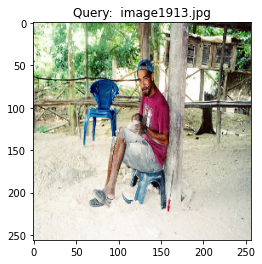

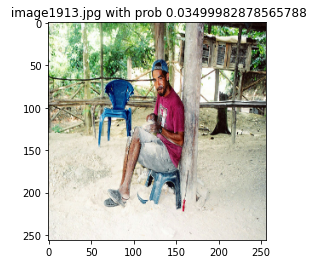

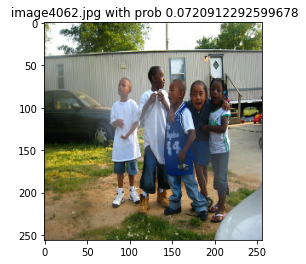

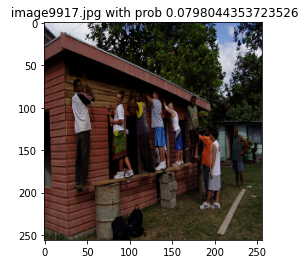

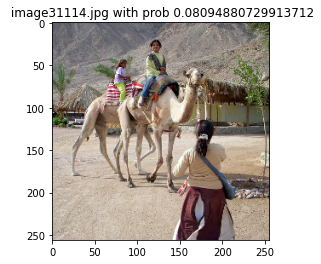

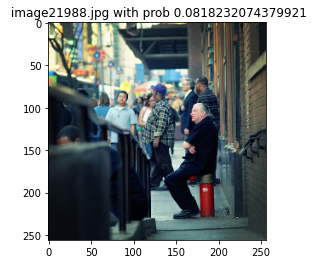

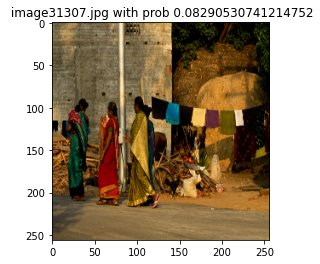

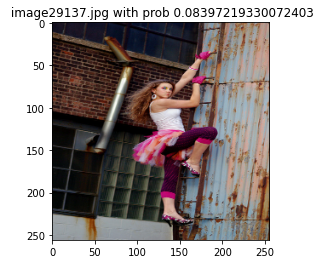

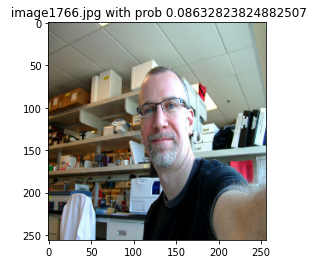

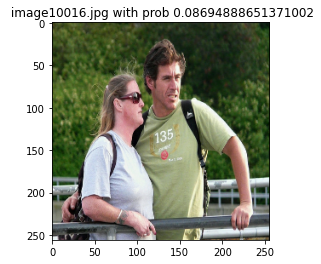

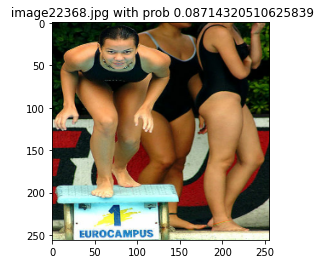

In [192]:
plot_most_sim(330)